### Using Pytorch for MNIST dataset Classification Problem

In [1]:
import torch
import torch.nn as nn
import torchvision # datasets 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 2
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001


#MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train = True, transform = transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train = False, transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([100, 1, 28, 28]) torch.Size([100])


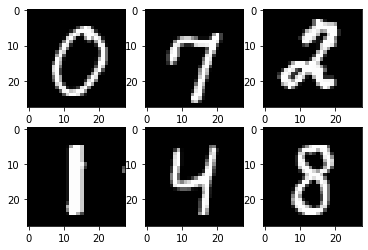

In [2]:
#Dataloader, Transformation
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

In [3]:
#Fully connected Recurrent Neural Network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # initial hidden state

        out, _ = self.rnn(x, h0)
        # out: batch_size, seq_length, hidden_size
        # out (N, 28, 128)
        out = out[:, -1, :]
        # out (N, 128)
        out = self.fc(out)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes)

In [4]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [5]:
# Training Loop (batch training)
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [100,1,28,28]
        # resized: [100, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss={loss.item():.4f}')

epoch 1 / 2, step 100/600, loss=1.1940
epoch 1 / 2, step 200/600, loss=0.6477
epoch 1 / 2, step 300/600, loss=0.6288
epoch 1 / 2, step 400/600, loss=0.5308
epoch 1 / 2, step 500/600, loss=0.4324
epoch 1 / 2, step 600/600, loss=0.2523
epoch 2 / 2, step 100/600, loss=0.3106
epoch 2 / 2, step 200/600, loss=0.2848
epoch 2 / 2, step 300/600, loss=0.2582
epoch 2 / 2, step 400/600, loss=0.2619
epoch 2 / 2, step 500/600, loss=0.3090
epoch 2 / 2, step 600/600, loss=0.1415


In [6]:
# Model evaluation, in test phase we dont need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100 * n_correct / n_samples
    print(f'Accuracy = {acc}')

Accuracy = 93.41


### Another variaiton of RNN: GRUs

In [9]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # initial hidden state

        out, _ = self.gru(x, h0)
        # out: batch_size, seq_length, hidden_size
        # out (N, 28, 128)
        out = out[:, -1, :]
        # out (N, 128)
        out = self.fc(out)
        return out

model = GRU(input_size, hidden_size, num_layers, num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Training Loop (batch training)
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [100,1,28,28]
        # resized: [100, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss={loss.item():.4f}')

# Model evaluation, in test phase we dont need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100 * n_correct / n_samples
    print(f'Accuracy = {acc}')

epoch 1 / 2, step 100/600, loss=0.7223
epoch 1 / 2, step 200/600, loss=0.2724
epoch 1 / 2, step 300/600, loss=0.2671
epoch 1 / 2, step 400/600, loss=0.1283
epoch 1 / 2, step 500/600, loss=0.1285
epoch 1 / 2, step 600/600, loss=0.2278
epoch 2 / 2, step 100/600, loss=0.1155
epoch 2 / 2, step 200/600, loss=0.1468
epoch 2 / 2, step 300/600, loss=0.1289
epoch 2 / 2, step 400/600, loss=0.0599
epoch 2 / 2, step 500/600, loss=0.1469
epoch 2 / 2, step 600/600, loss=0.0610
Accuracy = 97.34


In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # initial hidden state

        out, _ = self.lstm(x, (h0,c0))
        # out: batch_size, seq_length, hidden_size
        # out (N, 28, 128)
        out = out[:, -1, :]
        # out (N, 128)
        out = self.fc(out)
        return out

model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Training Loop (batch training)
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [100,1,28,28]
        # resized: [100, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss={loss.item():.4f}')

# Model evaluation, in test phase we dont need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100 * n_correct / n_samples
    print(f'Accuracy = {acc}')

epoch 1 / 2, step 100/600, loss=0.7978
epoch 1 / 2, step 200/600, loss=0.4399
epoch 1 / 2, step 300/600, loss=0.1932
epoch 1 / 2, step 400/600, loss=0.2925
epoch 1 / 2, step 500/600, loss=0.1744
epoch 1 / 2, step 600/600, loss=0.1176
epoch 2 / 2, step 100/600, loss=0.1347
epoch 2 / 2, step 200/600, loss=0.1136
epoch 2 / 2, step 300/600, loss=0.0324
epoch 2 / 2, step 400/600, loss=0.0353
epoch 2 / 2, step 500/600, loss=0.2934
epoch 2 / 2, step 600/600, loss=0.0916
Accuracy = 97.04
